# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [116]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [117]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn, split_dataset
# from common_utils import split_dataset, preprocess_dataset

# def preprocess(df):
#     # YOUR CODE HERE
    
#     X_train, y_train, X_test, y_test = split_dataset(df, 'filename', 0.30, 1)
#     X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
#     return X_train_scaled, y_train, X_test_scaled, y_test

# import the x train and y train datasets
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()
#change to train test split?
X_train, y_train, X_test, y_test = split_dataset(df, 'filename', 0.30, 1)
print(X_train)
print(y_train)

class BatchCustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)
# X_train, y_train = X_train_scaled, y_train

            tempo  total_beats  average_beats  chroma_stft_mean  \
5358    95.703125         1874     187.400000          0.567137   
642    103.359375          477      79.500000          0.549953   
7565    78.302557          875     125.000000          0.646271   
9584   112.347147         3430     201.764706          0.599859   
9374   198.768029         6870     214.687500          0.724747   
...           ...          ...            ...               ...   
7813   151.999081         3349     176.263158          0.591543   
10955  107.666016         3107     194.187500          0.514742   
905    161.499023        16138     375.302326          0.492115   
5192    92.285156          247      61.750000          0.526634   
235     95.703125          602      86.000000          0.500863   

       chroma_stft_var  chroma_cq_mean  chroma_cq_var  chroma_cens_mean  \
5358          0.088985        0.515726       0.076869          0.262738   
642           0.088597        0.488051       

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [118]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
#     x train scaled and y train goes in here
#     x train scaled dict is the list of of 4/5 matrices
#     x val scaled dict is the last 1/5 matrix for testing
#     y train dict is the list of 4/5 labels
#     y val dict is the last 1/5 labels for testing
    
#     It will not differ by batch size. X_train_scaled_dict[128] is a list of train dataset for the different folds, and you should have 5 elements in the list in total. It is the same as X_train_scaled_dict[256], etc
#     X_train_scaled_dict should look like {128:[list of 5 folds] 256:[list of 5 folds], 512: [list of 5 folds], 1024: [list of 5 folds]}
#     y_train_dict is a dictionary of 4x5 elements as well, each element is the matrix of labels to train towards
    
#     customdataset = xtrain, ytrain
    
#     cv = KFold(n_splits=5, shuffle=True, random_state=1)
#     for train_idx, test_idx in cv.split(X_train, y_train):
#         X_train_scaled_dict, y_train_dict  = X_train[train_idx], y_train[train_idx]
#         X_val_scaled_dict, y__val_dict = X_train[test_idx], y_train[test_idx]
    batch_sizes = parameters  # Default to batch size of 32 if not provided
    
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
#     X_train_scaled_dict = {batch_size: [] for batch_size in batch_sizes}
#     X_val_scaled_dict = {batch_size: [] for batch_size in batch_sizes}
#     y_train_dict = {batch_size: [] for batch_size in batch_sizes}
#     y_val_dict = {batch_size: [] for batch_size in batch_sizes}

    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    for batch_size in batch_sizes:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []
    
    X_train = X_train[:, 1:]
    for train_idx, val_idx in cv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        standard_scaler = preprocessing.StandardScaler()
        X_train_fold_scaled = standard_scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = standard_scaler.fit_transform(X_val_fold)
        
        for batch_size in batch_sizes:
            X_train_scaled_dict[batch_size].append(X_train_fold_scaled)
            X_val_scaled_dict[batch_size].append(X_val_fold_scaled)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128,256,512,1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)
# sanity check: note that 6751 / 8439 is around 80%
# print(X_train_scaled_dict)
print(len(X_train_scaled_dict))
print(len(X_train_scaled_dict[128]))
print(len(X_train_scaled_dict[128][0]))
print(len(X_train_scaled_dict[256][2][0]))
print(X_train_scaled_dict[128][0])

# sanity check: this is the other 20%
# print(X_val_scaled_dict)
print(len(X_val_scaled_dict))
print(len(X_val_scaled_dict[128]))
print(len(X_val_scaled_dict[128][0]))
print(len(X_val_scaled_dict[256][2][0]))
print(X_val_scaled_dict[128][0])

# print(y_train_dict)
print(len(y_train_dict))
print(len(y_train_dict[128]))
print(len(y_train_dict[128][0]))
print(y_train_dict[128][0])
print(y_train_dict[128][0][1])

# print(y_val_dict)
print(len(y_val_dict))
print(len(y_val_dict[128]))
print(len(y_val_dict[128][0]))
print(y_val_dict[128][0])
print(y_val_dict[128][0][1])

4
5
6751
77
[[-0.49106531  0.01265512  0.05686221 ...  1.18119068 -0.38849754
  -1.03574435]
 [-0.79797693 -0.98345107 -0.22072241 ...  0.05499416  0.55841098
   0.96548922]
 [-0.71053897 -0.56340629  1.33516163 ...  1.38367374 -0.88628092
   0.96548922]
 ...
 [ 2.64264068  1.74732306 -1.15502705 ...  0.18848147 -0.14767633
  -1.03574435]
 [-0.8485064  -1.1473147  -0.59740884 ... -0.8292896  -0.76430263
  -1.03574435]
 [-0.77051526 -0.92344468 -1.01371018 ... -1.33465669  0.51198613
   0.96548922]]
4
5
1688
77
[[-0.82343749 -1.10706956 -0.41688652 ... -0.16468361 -0.68326526
  -1.02763283]
 [ 0.98136812  2.11967717  0.5703326  ...  1.19125302 -0.5304174
  -1.02763283]
 [ 2.26269824  1.56816612 -0.46104367 ... -0.4657886  -0.76811365
  -1.02763283]
 ...
 [-0.84217921 -1.13612265 -1.27788254 ... -0.73719861  0.23449046
   0.97311021]
 [-0.82817678 -1.14106785  0.41268208 ...  0.68536118 -0.9647467
  -1.02763283]
 [-0.6952614  -0.71454386 -0.90409557 ...  0.72641355 -0.53359531
   0.97311

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [119]:
def intialise_loaders_batch(X_train_scaled, y_train, X_test_scaled, y_test, batch_size):

#     print("X_train_scaled in initialise loaders batch")
#     print(len(X_train_scaled[0]))
    train_data = BatchCustomDataset(X_train_scaled,y_train)
#     print(len(train_data[1]))
    test_data = BatchCustomDataset(X_test_scaled,y_test)
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    return train_dataloader, test_dataloader

def train_loop_batch(dataloader, model, loss_fn, optimizer, x_test, y_test):
    # put within the epochs loop
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     print(size)
#     print(num_batches)
#     train_loss, train_correct = 0, 0
    acc_ = []
#     print
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
#         print(len(X[0]))
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         print(len(x_test[0]))
        pred = model(torch.tensor(x_test, dtype=torch.float))
#         print(pred)
#         print(y_test)
#         acc__ = (pred.argmax(1) == torch.tensor(y_test, dtype=torch.float).argmax(1)).type(torch.float).mean()
        acc__ = (pred.argmax(1) == torch.tensor(y_test, dtype=torch.float)).type(torch.float).mean()
        
        acc_.append(acc__.item())
        
    return acc_
#         train_loss += loss.item()
#         train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
#     train_loss /= num_batches
#     train_correct /=size

#     return train_loss, train_correct

# YOUR CODE HERE
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    model = MLP(77,128,2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    
    cross_validation_times = []
#     acc = []
    foldaccuracyofabatchsize = []
    timeforafoldforthatbatchsize = []
    meanaccuracyofabatchsizelist = []
    meantimeofabatchsizelist = []
    for batch_size in batch_sizes:
        print(foldaccuracyofabatchsize)
        print(timeforafoldforthatbatchsize)
        foldaccuracyofabatchsize = []
        timeforafoldforthatbatchsize = []
        for idxy in range(0,5):
            x_train = X_train_scaled_dict[batch_size][idxy]
            y_train = y_train_dict[batch_size][idxy]
            x_test = X_val_scaled_dict[batch_size][idxy]
            y_test = y_val_dict[batch_size][idxy]
            print(foldaccuracyofabatchsize)
            print(timeforafoldforthatbatchsize)
#             acc_ = []
#             time = []
#             print(len(x_train[0]))
            train_dataloader, test_dataloader = intialise_loaders_batch(x_train, y_train, x_test, y_test, batch_size)
#             print(train_dataloader.dataset)
            for epoch in range(100):
                start = time.time()
                acc_ = train_loop_batch(train_dataloader, model, loss_fn, optimizer, x_test, y_test)
                end = time.time()
                # for a fold, the list of accuracies for the batches of that epoch^
                print("an epoch" + str(epoch))
                if epoch==99:
                    foldaccuracyofabatchsize.append(np.mean(np.array(acc_), axis = 0))
#                     the accuracy for the last epoch of that fold - the fold accuracy for that batch size, length is 5
                    timeforafoldforthatbatchsize.append(end-start)
        meanaccuracyofabatchsizelist.append(np.mean(np.array(foldaccuracyofabatchsize), axis = 0))
        meantimeofabatchsizelist.append(np.mean(np.array(timeforafoldforthatbatchsize), axis = 0))
        # length should be 4^

#         acc_ = []
#         for no_hidden in hidden_units:
        
#             model = FFN(no_inputs, no_hidden, no_outputs)
    
#             loss_fn = torch.nn.CrossEntropyLoss()
#             optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
#             for epoch in range(100):
#                 pred = model(torch.tensor(x_train, dtype=torch.float))
#                 loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))
    
#                 # Backpropagation
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
    
#             pred = model(torch.tensor(x_test, dtype=torch.float))
#             acc__ = (pred.argmax(1) == torch.tensor(y_test, dtype=torch.float).argmax(1)).type(torch.float).mean()
    
#             acc_.append(acc__.item())
#             accuracylistfor5foldsforabatchsize.append(acc_)
#         acc.append(accuracylistfor5foldsforabatchsize.mean)
#         acc.append(acc_)
    
#     cv_acc = np.mean(np.array(acc), axis = 0)
#     cross_validation_accuracies = cv_acc
    cross_validation_accuracies = meanaccuracyofabatchsizelist
    cross_validation_times = meantimeofabatchsizelist
    print(cross_validation_accuracies)
    print(cross_validation_times)
    return cross_validation_accuracies, cross_validation_times

batch_sizes = [128,256,512,1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes)


[]
[]
[]
[]
an epoch0
an epoch1
an epoch2
an epoch3
an epoch4
an epoch5
an epoch6
an epoch7
an epoch8
an epoch9
an epoch10
an epoch11
an epoch12
an epoch13
an epoch14
an epoch15
an epoch16
an epoch17
an epoch18
an epoch19
an epoch20
an epoch21
an epoch22
an epoch23
an epoch24
an epoch25
an epoch26
an epoch27
an epoch28
an epoch29
an epoch30
an epoch31
an epoch32
an epoch33
an epoch34
an epoch35
an epoch36
an epoch37
an epoch38
an epoch39
an epoch40
an epoch41
an epoch42
an epoch43
an epoch44
an epoch45
an epoch46
an epoch47
an epoch48
an epoch49
an epoch50
an epoch51
an epoch52
an epoch53
an epoch54
an epoch55
an epoch56
an epoch57
an epoch58
an epoch59
an epoch60
an epoch61
an epoch62
an epoch63
an epoch64
an epoch65
an epoch66
an epoch67
an epoch68
an epoch69
an epoch70
an epoch71
an epoch72
an epoch73
an epoch74
an epoch75
an epoch76
an epoch77
an epoch78
an epoch79
an epoch80
an epoch81
an epoch82
an epoch83
an epoch84
an epoch85
an epoch86
an epoch87
an epoch88
an epoch89
an epoch

an epoch96
an epoch97
an epoch98
an epoch99
[0.9998902943399217, 1.0]
[2.494239568710327, 3.2124834060668945]
an epoch0
an epoch1
an epoch2
an epoch3
an epoch4
an epoch5
an epoch6
an epoch7
an epoch8
an epoch9
an epoch10
an epoch11
an epoch12
an epoch13
an epoch14
an epoch15
an epoch16
an epoch17
an epoch18
an epoch19
an epoch20
an epoch21
an epoch22
an epoch23
an epoch24
an epoch25
an epoch26
an epoch27
an epoch28
an epoch29
an epoch30
an epoch31
an epoch32
an epoch33
an epoch34
an epoch35
an epoch36
an epoch37
an epoch38
an epoch39
an epoch40
an epoch41
an epoch42
an epoch43
an epoch44
an epoch45
an epoch46
an epoch47
an epoch48
an epoch49
an epoch50
an epoch51
an epoch52
an epoch53
an epoch54
an epoch55
an epoch56
an epoch57
an epoch58
an epoch59
an epoch60
an epoch61
an epoch62
an epoch63
an epoch64
an epoch65
an epoch66
an epoch67
an epoch68
an epoch69
an epoch70
an epoch71
an epoch72
an epoch73
an epoch74
an epoch75
an epoch76
an epoch77
an epoch78
an epoch79
an epoch80
an epoch8

an epoch87
an epoch88
an epoch89
an epoch90
an epoch91
an epoch92
an epoch93
an epoch94
an epoch95
an epoch96
an epoch97
an epoch98
an epoch99
[0.9999576849596841, 1.0, 1.0, 0.9999576849596841]
[1.5529866218566895, 1.7287111282348633, 1.588524341583252, 1.5021321773529053]
an epoch0
an epoch1
an epoch2
an epoch3
an epoch4
an epoch5
an epoch6
an epoch7
an epoch8
an epoch9
an epoch10
an epoch11
an epoch12
an epoch13
an epoch14
an epoch15
an epoch16
an epoch17
an epoch18
an epoch19
an epoch20
an epoch21
an epoch22
an epoch23
an epoch24
an epoch25
an epoch26
an epoch27
an epoch28
an epoch29
an epoch30
an epoch31
an epoch32
an epoch33
an epoch34
an epoch35
an epoch36
an epoch37
an epoch38
an epoch39
an epoch40
an epoch41
an epoch42
an epoch43
an epoch44
an epoch45
an epoch46
an epoch47
an epoch48
an epoch49
an epoch50
an epoch51
an epoch52
an epoch53
an epoch54
an epoch55
an epoch56
an epoch57
an epoch58
an epoch59
an epoch60
an epoch61
an epoch62
an epoch63
an epoch64
an epoch65
an epoch66

5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

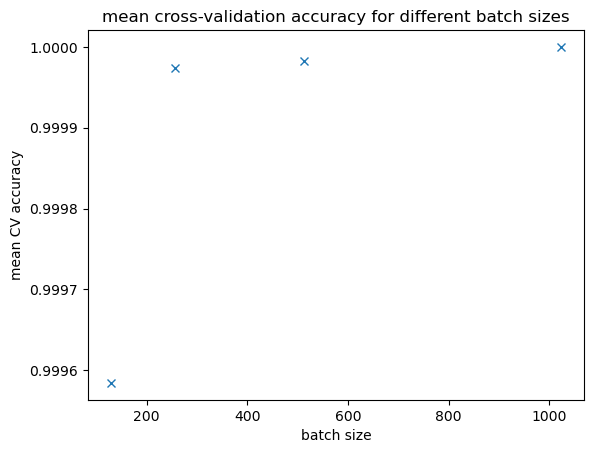

In [120]:
# YOUR CODE HERE
# plt.figure(1)
plt.plot(batch_sizes, cross_validation_accuracies, marker = 'x', linestyle = 'None')
plt.title('mean cross-validation accuracy for different batch sizes')
plt.xlabel('batch size')
plt.ylabel('mean CV accuracy')
plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [121]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Last Epoch Time': cross_validation_times
                  })

df

,Batch Size,Last Epoch Time
0,128,4.699202
1,256,2.675208
2,512,1.577411
3,1024,1.148944


In [122]:
# YOUR CODE HERE
optimal_batch_size = 1024
reason = "Lowest last epoch time and highest mean cross-validation accuracy"